In [10]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cvx.covariance.ewma import iterated_ewma, regularize_covariance
from experiments.utils.experiment_utils import log_likelihood

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [8]:
data = pd.read_csv("/Users/kasper/Documents/Stanford/Research/Data/SP500/asset_data_2000_to_2023.csv", index_col=0, parse_dates=True)

data = data.drop(["TICKER", "PERMCO"], axis=1)
prices = pd.pivot_table(data, values='PRC', index='date', columns='PERMNO', fill_value=None)
prices.index = pd.to_datetime(prices.index, format="%Y-%m-%d")
returns = prices.pct_change().dropna(axis=0, how="all")

In [16]:
iewma = list(iterated_ewma(returns.loc['2010-01-01':], vola_halflife=63, cov_halflife=125, min_periods_vola=21, min_periods_cov=250))
iewma = {iterate.time: iterate.covariance for iterate in iewma}

iewma_clip = list(iterated_ewma(returns.loc['2010-01-01':], vola_halflife=63, cov_halflife=125, min_periods_vola=21, min_periods_cov=250, clip_at=4.2))
iewma_clip = {iterate.time: iterate.covariance for iterate in iewma_clip}

iewma_reg = list(iterated_ewma(returns.loc['2010-01-01':], vola_halflife=63, cov_halflife=125, min_periods_vola=21, min_periods_cov=250))
iewma_reg = {iterate.time: iterate.covariance for iterate in iewma_reg}
iewma_reg = dict(regularize_covariance(iewma_reg, r=50))

iewma_clip_reg = list(iterated_ewma(returns.loc['2010-01-01':], vola_halflife=63, cov_halflife=125, min_periods_vola=21, min_periods_cov=250, clip_at=4.2))
iewma_clip_reg = {iterate.time: iterate.covariance for iterate in iewma_clip_reg}
iewma_clip_reg = dict(regularize_covariance(iewma_clip_reg, r=50))

In [12]:
# Prescient predictor
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding year
    year = t.year
    cov = np.cov(returns.loc[returns.index.year == year].values, rowvar=False)
    mean = np.mean(returns.loc[returns.index.year == year].values, axis=0)
    prescient[t] = pd.DataFrame(cov+np.outer(mean,mean), index=returns.columns, columns=returns.columns)

# Log-likelihoods

In [15]:
iewma_reg

<generator object regularize_covariance at 0x7fa91b347270>

In [17]:
predictors = [iewma, iewma_clip, iewma_reg, iewma_clip_reg, prescient]

ll = {}

names = ["No clipping or regularization", "Clip at 4.2 sigma", "Low rank 50", "Clip at 4.2 sigma, low rank 50", "Prescient"]

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = returns.loc[pd.Series(predictor).index].values[1:]
    times = pd.Series(predictor).index[1:]
    Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]

    # compute log-likelihood for 100*r since otherwise det(Sigma) is numerically zero
    ll[names[i]] = pd.Series(log_likelihood(returns_temp*100, Sigmas_temp*10000), index=times) 

Computing No clipping or regularization log-likelihood...
Computing Clip at 4.2 sigma log-likelihood...
Computing Low rank 50 log-likelihood...
Computing Clip at 4.2 sigma, low rank 50 log-likelihood...
Computing Prescient log-likelihood...


Mean Std Max

No clipping or regularization
592.534 2002.6 13633.03

Clip at 4.2 sigma
609.448 2016.349 13732.104

Low rank 50
403.692 1145.822 7522.574

Clip at 4.2 sigma, low rank 50
420.362 1164.703 7655.121

Prescient
0.0 0.0 0.0


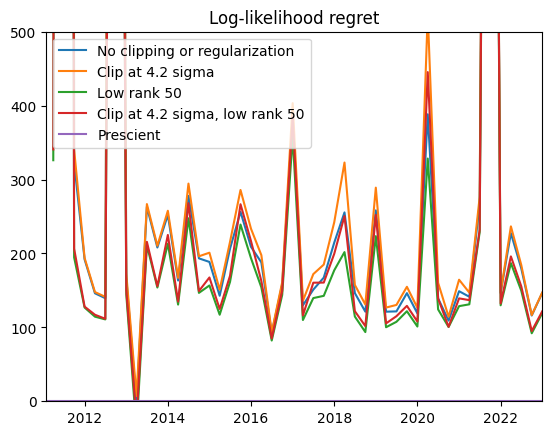

In [18]:
print("Mean", "Std", "Max")
for i, name in enumerate(ll):
    regret = (ll["Prescient"] - ll[name]).resample("Q").mean()
    plt.plot(regret, label=name)

    print("\n" + name)
    print(np.round(regret.mean(),3), np.round(regret.std(),3), np.round(regret.max(),3))
plt.legend()
plt.title("Log-likelihood regret")
plt.ylim(0,500)
plt.xlim([*predictors[0].keys()][0], returns.index[-1]);